In [1]:
# Timeseries generator, 'last n datapoint window' input, 'next k datapoint window' output
# Works with multiple column pandas dataframes

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Flatten, Reshape
from tensorflow.keras.models import Model

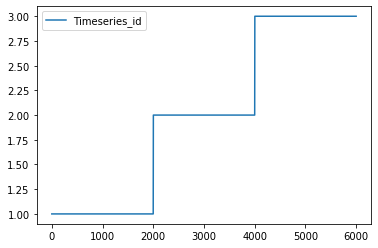

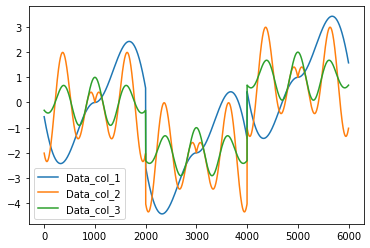

In [3]:
# Generating data and labels
def dummy_function(x):
    timeseries_nbr = 1
    a = 0.4 * np.sin(0.3 * x) * np.abs(x)
    b = np.log1p(np.abs(x)) * np.cos(x)
    c = np.exp(-x**2 / 100) * np.cos(x)
    return [timeseries_nbr, a, b, c]

x = np.arange(-10, 10, 0.01)

df1 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])

df2 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])
df2 = df2 - 2
df2['Timeseries_id'] = 2

df3 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])
df3 = df3 + 1
df3['Timeseries_id'] = 3

df = pd.concat([df1, df2, df3]).reset_index().drop(columns='index')

COLUMN_NBR = df.shape[1] - 1 # timeseries id is not data column

df[['Timeseries_id']].plot()
df[['Data_col_1', 'Data_col_2', 'Data_col_3']].plot()

In [4]:
# Create train, validation and test set IDs

def get_window_index_list(x, timeseries_id_column, window_length, prediction_length):
  idx_list = []
  for mr in x[timeseries_id_column].unique():
    temp = x[x[timeseries_id_column] == mr]
    
    start_index = temp.iloc[0,:].name
    
    window_nbr = len(temp) - window_length - prediction_length + 1
    if window_nbr<1 :
      window_nbr = 1
    
    for i in range(window_nbr):
      idx_list.append(start_index + i)
  
  return idx_list

# Input, output data for model.
WINDOW_LENGTH = 16
PREDICTION_LENGTH = 1
idx_list = get_window_index_list(df,
                                 timeseries_id_column='Timeseries_id',
                                 window_length=WINDOW_LENGTH,
                                 prediction_length=PREDICTION_LENGTH)

# Create train, validation and test set IDs
train_idx, test_idx = train_test_split(idx_list, random_state=2020, test_size=0.20)
train_idx, val_idx = train_test_split(train_idx, random_state=2020, test_size=0.20)

print('Number of train samples:', len(train_idx))
print('Number of validation samples:', len(val_idx))
print('Number of test samples:', len(test_idx))

Number of train samples: 3808
Number of validation samples: 953
Number of test samples: 1191


In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode, id_list, x, window_length, prediction_length, exp_dim=False,
                 sample_weights=None, batch_size=8, random_state=2020, shuffle=False):
        self.mode = mode # fit / val / predict
        self.id_list = id_list # data id: if data must be loaded it is easier to work with ids
        self.x = x # data
        self.column_nbr = self.x.shape[1] - 1 # 1 column is mouserun -> decrease by one
        self.window_length = window_length
        self.prediction_length = prediction_length
        self.exp_dim = exp_dim # For CNN
        self.sample_weights = sample_weights # ignored if None
        self.batch_size = batch_size
        self.random_state = random_state
        self.shuffle = shuffle
          
        # Shuffle ID list before first epoch if shuffling enabled
        self.on_epoch_end()
      
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find IDs of current batch
        id_list_batch = [self.id_list[k] for k in indexes]
        
        # Ceate data
        batch_x = self.__generate_X(id_list_batch)
        
        if self.mode == 'fit' or self.mode == 'val':
            batch_y = self.__generate_y(id_list_batch)
            if self.sample_weights != None:
                batch_sample_weight = self.__generate_sample_weight(id_list_batch)
                return batch_x, batch_y, batch_sample_weight
            return batch_x, batch_y
        
        elif self.mode == 'predict':
            return batch_x
        
        else:
            raise AttributeError('The mode parameter should be set to "fit", "val" or "predict"!')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, id_list_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.exp_dim:
            # For CNN an 'image' like input is more convinent
            X = np.zeros((self.batch_size, self.window_length, self.column_nbr, 1))
        else:
            X = np.zeros((self.batch_size, self.window_length, self.column_nbr))
        
        # Generate data
        for i, ID in enumerate(id_list_batch):
            # Store samples
            start_idx = ID
            end_idx = ID+self.window_length
            
            if self.mode == 'fit':
                temp = self.x.iloc[start_idx:end_idx, :].values[:, 1:] # values[:, 1:] is all row of data except first column(timeseries id)
                #print('Data shape:', temp.shape)
                
                #
                # IF ON THE FLY AUGMENTATION NEEDED IT SHOULD BE HERE
                # Current code is not suitable for multiplying sample with augmentation
                # for example: noise, random mirroring, etc.
                #
                
            if self.mode == 'val' or self.mode == 'predict':
                temp = self.x.iloc[start_idx:end_idx, :].values[:, 1:] # values[:, 1:] is all row of data except first column(timeseries id)
                
            #
            # IF ON THE FLY NORMALIZATION NEEDED IT SHOULD BE HERE
            # for example: temp = temp / 255.
            #
            
            if self.exp_dim:
            # For CNN an 'image' like input is more convinent
                temp2 = np.expand_dims(temp, axis=-1)
            else:
                temp2 = temp
          
            # Copy finished sample to current batch
            X[i] = temp2
            
        return X
    
    def __generate_y(self, list_IDs_batch):
        # Initialization
        y = np.zeros((self.batch_size, self.prediction_length, self.column_nbr))

        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            # Store samples
            start_idx = ID+self.window_length
            end_idx = ID+self.window_length+self.prediction_length
            
            y[i] = self.x.iloc[start_idx:end_idx, :].values[:, 1:] # values[:, 1:] is all row of data except first column(mouserun)
            #print(y[i].shape)
        #
        # IF ON THE FLY NORMALIZATION NEEDED IT SHOULD BE HERE
        # for example: y = y / 255.
        #
            
        return y
    
    def __generate_sample_weight(self, id_list_batch):
        # TODO: implement if needed
        return sample_weight

In [6]:
# Set up generators for training
BATCH_SIZE = 64
train_generator = DataGenerator(mode='fit',
                                id_list=train_idx,
                                x=df,
                                window_length=WINDOW_LENGTH,
                                prediction_length=PREDICTION_LENGTH,
                                exp_dim=True,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
val_generator = DataGenerator(mode='val',
                              id_list=val_idx,
                              x=df,
                              window_length=WINDOW_LENGTH,
                              prediction_length=PREDICTION_LENGTH,
                              exp_dim=True,
                              batch_size=128)

In [7]:
# CNN model
def create_model():   
    input0 = Input(shape=(WINDOW_LENGTH,COLUMN_NBR,1))
  
    time00 = Conv2D(2, kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 1), activation='relu') (input0)
    time01 = Conv2D(2,  kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 2), activation='relu') (input0)
    time02 = Conv2D(2,  kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 3), activation='relu') (input0)
    time03 = Conv2D(2,  kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 4), activation='relu') (input0)
    concat0 = Concatenate(axis=-1) ([time00, time01, time02, time03])
  
    time10 = Conv2D(2, kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 1), activation='relu') (concat0)
    time11 = Conv2D(2, kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 2), activation='relu') (concat0)
    time12 = Conv2D(2, kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 3), activation='relu') (concat0)
    time13 = Conv2D(2,  kernel_size=(3, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 4), activation='relu') (concat0)
    concat1 = Concatenate(axis=-1) ([time10, time11, time12, time13])
  
    row_flatten = Conv2D(16, kernel_size=(1, COLUMN_NBR), strides=(1, 1), padding='valid', dilation_rate=(1, 1), activation='relu') (concat1)
  
    depth_reduction = Conv2D(8, kernel_size=(1, 1), strides=(1, 1), padding='valid', dilation_rate=(1, 1), activation='relu') (row_flatten)
  
    flatten = Flatten() (depth_reduction)
  
    dense = Dense(8, activation='relu', name='representation_layer') (flatten)
  
    output0 = Dense(COLUMN_NBR) (dense)
    output0 = Reshape((PREDICTION_LENGTH,COLUMN_NBR)) (output0)
   
    model = Model(input0, output0)
  
    model.compile(optimizer='adam', loss='mse')

    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 3, 1)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 3, 2)     8           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 3, 2)     8           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 3, 2)     8           input_1[0][0]                    
______________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']


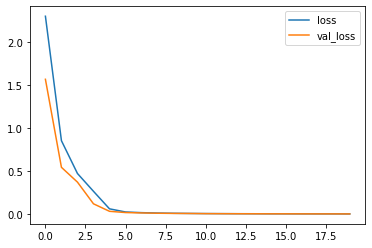

In [8]:
# Training NN
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    verbose=0)

# Plot the training and validation loss for each epoch
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [9]:
# Prediction
predict_generator = DataGenerator(mode='predict',
                                  id_list=test_idx,
                                  x=df,
                                  window_length=WINDOW_LENGTH,
                                  prediction_length=PREDICTION_LENGTH,
                                  exp_dim=True,
                                  batch_size=1)

predictions = model.predict(predict_generator)